
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## Climate emulator output generation

inputs required: 
  * historical wave and water level conditions
  * emulator output - synthetic wave and water level conditions
  
in this notebook:
  * plot the historical and synthetic values of the analyzed variables
  * generation of hourly values of the synthetic time series
  
  


In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.climate_emulator import Climate_Emulator
from teslakit.waves import AWL, Aggregate_WavesFamilies, Intradaily_Hydrograph
from teslakit.util.time_operations import xds_limit_dates, xds_reindex_daily, xds_common_dates_daily

from teslakit.plotting.climate_emulator import Plot_Complete



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/nico/Projects/TESLA-kit/TeslaKit/data'
db = Database(p_data)

# set site
db.SetSite('ROI')

# climate emulator object
CE = Climate_Emulator(db.paths.site.EXTREMES.climate_emulator)
CE.Load()

n_sims_DWTs = 10



## Historical Waves and Climate Data

In [3]:
# Generate historical complete hourly data and 
HIST_COMPLETE_h = db.Generate_HIST_Complete()

# set historical AT at same reference than simulated AT
HIST_COMPLETE_h['AT'] = HIST_COMPLETE_h['AT'] - np.nanmin(HIST_COMPLETE_h['AT'])

# calculate AWL, TWL and level
HIST_COMPLETE_h['AWL'] = AWL(HIST_COMPLETE_h.Hs, HIST_COMPLETE_h.Tp)
HIST_COMPLETE_h['TWL'] = HIST_COMPLETE_h['AWL'] + HIST_COMPLETE_h['AT'] + HIST_COMPLETE_h['MMSL']
HIST_COMPLETE_h['level'] = HIST_COMPLETE_h['AT'] + HIST_COMPLETE_h['MMSL']

# make a daily freq. file
HIST_COMPLETE_d = xds_reindex_daily(HIST_COMPLETE_h)

# make a storm freq. file
HIST_COMPLETE_S = HIST_COMPLETE_d.sel(time=CE.WVS_MS.time)


# store all data
db.Save_HIST_Complete_hourly(HIST_COMPLETE_h)
db.Save_HIST_Complete_daily(HIST_COMPLETE_d)
db.Save_HIST_Complete_storms(HIST_COMPLETE_S)

print(HIST_COMPLETE_h)


<xarray.Dataset>
Dimensions:      (time: 1331113)
Coordinates:
  * time         (time) datetime64[ns] 1880-06-01 ... 2018-04-08
Data variables:
    observed     (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    ntr          (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    sigma        (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    AT           (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    AWT          (time) float64 2.0 2.0 2.0 2.0 2.0 2.0 ... nan nan nan nan nan
    DWT          (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    Hs           (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    Tp           (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    Dir          (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    sea_Hs       (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    sea_Tp       (time) float64 nan nan nan nan nan nan 

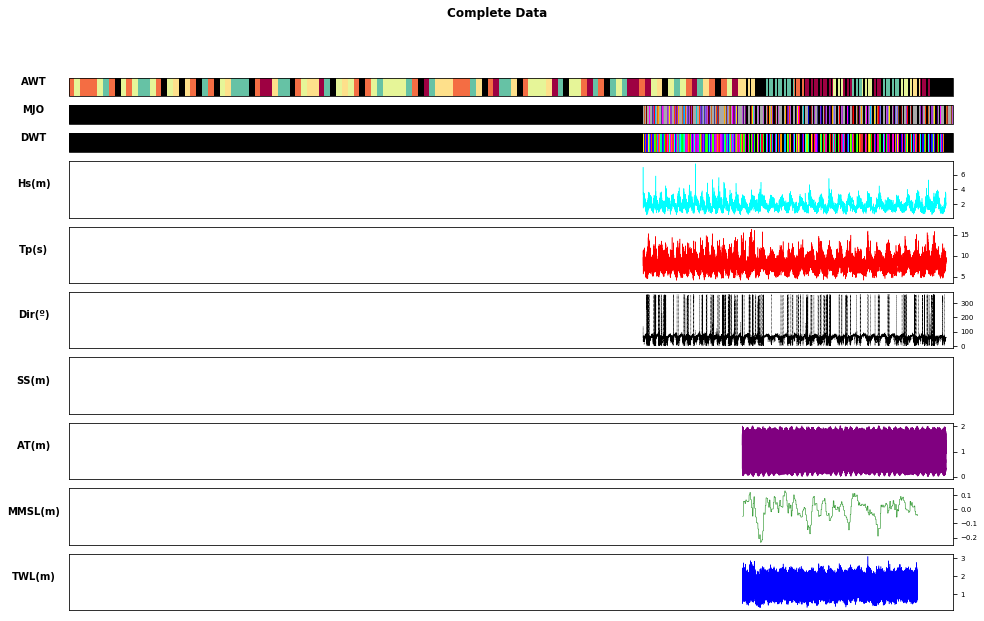

In [5]:
# Plot Historical 

Plot_Complete(HIST_COMPLETE_h);


## Simulated Waves and Climate Data

In [5]:
# --------------------------------------
# aux. functions

def waves_hourly(CE, n_sims_DWTs, n_sim_ce=0):
    '''
    Generate hourly simulation output. 
    
    - join DWTs-WVs Climate emulator simulations for all n_sims_DWTs
    - aggregate simulated waves storms
    - generate hourly hydrographs
    - calculates AWL
    
    return xarray.Dataset with dims: n_sim (DWTs-WVs), time (hourly)
    '''

    # iterate simulations
    ls_hy = []
    for n in range(n_sims_DWTs):
        _, TCS_sim, WVS_upd = CE.LoadSim(n_sim = n)    
        WVS_upd = WVS_upd.isel(n_sim = n_sim_ce)  # (one CE sim. for each DWT sim.)
        TCS_sim = TCS_sim.isel(n_sim = n_sim_ce)

        # Aggregate waves families
        wvs_agr = Aggregate_WavesFamilies(WVS_upd)

        # Calculate Intradaily hourly hydrographs for simulated storms
        hy = Intradaily_Hydrograph(wvs_agr, TCS_sim)
        ls_hy.append(hy)
        
    # combine hourly simulations
    hy = xr.concat(ls_hy, 'n_sim')

    # Calculate hourly Atmospheric Water Level and Total Water Level
    hy['AWL'] = AWL(hy.Hs, hy.Tp)

    return hy


In [6]:
# --------------------------------------
# Climate Emulator extremes model output

# Generate all MaxStorm DWTs-WVS-TCS simulations as a pandas.Dataframe (adding time and n_sim as columns)
WVS_sim = CE.LoadSim_All()
db.Save_CE_AllSims(WVS_sim)

# Generate hourly waves xarray.Dataset using intradaily hydrographs
WVS_sim_h = waves_hourly(CE, n_sims_DWTs)  
db.Save_SIM_Waves_hourly(WVS_sim_h)

print(WVS_sim_h)


<xarray.Dataset>
Dimensions:  (n_sim: 10, time: 8765833)
Coordinates:
  * time     (time) object 2000-01-01 2000-01-01T01:00:00 ... 3000-01-01
Dimensions without coordinates: n_sim
Data variables:
    Hs       (n_sim, time) float64 2.063 2.056 2.05 ... 0.3754 0.3539 0.3325
    Tp       (n_sim, time) float32 9.734059 9.734059 ... 6.9411745 13.976438
    Dir      (n_sim, time) float32 38.314224 38.314224 ... 45.322403 349.13596
    SS       (n_sim, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AWL      (n_sim, time) float64 0.6007 0.5997 0.5988 ... 0.1827 0.1774 0.3462
Attributes:
    source:   teslakit_v0.9.1



## Complete Simulation: load covariates and merge with hourly waves

In [7]:
# --------------------------------------
# Covariates: AWTs, DWTs, MJO, MMSL, AT

# Generate hourly covariates data
CVS_sim_h = db.Generate_SIM_Covariates(total_sims=n_sims_DWTs)
db.Save_SIM_Covariates_hourly(CVS_sim_h)


# --------------------------------------
# Complete simulation output 
d1, d2 = xds_limit_dates([WVS_sim_h, CVS_sim_h])
WVS_sim_h = WVS_sim_h.sel(time = slice(d1, d2))
CVS_sim_h = CVS_sim_h.sel(time = slice(d1, d2))

# merge all data
SIM_COMPLETE_h = xr.merge([WVS_sim_h, CVS_sim_h])

# calculate TWL and level
SIM_COMPLETE_h['TWL'] = SIM_COMPLETE_h['AWL'] + SIM_COMPLETE_h['SS'] + SIM_COMPLETE_h['AT'] + SIM_COMPLETE_h['MMSL']
SIM_COMPLETE_h['level'] = SIM_COMPLETE_h['SS'] + SIM_COMPLETE_h['AT'] + SIM_COMPLETE_h['MMSL']

# make a daily freq. file
SIM_COMPLETE_d = xds_reindex_daily(SIM_COMPLETE_h)

# store all data
db.Save_SIM_Complete_hourly(SIM_COMPLETE_h)
db.Save_SIM_Complete_daily(SIM_COMPLETE_d)


print(SIM_COMPLETE_h)


<xarray.Dataset>
Dimensions:  (n_sim: 10, time: 8765832)
Coordinates:
  * time     (time) object 2000-01-01 ... 2999-12-31T23:00:00
Dimensions without coordinates: n_sim
Data variables:
    Hs       (n_sim, time) float64 2.063 2.056 2.05 ... 0.3969 0.3754 0.3539
    Tp       (n_sim, time) float32 9.734059 9.734059 ... 6.9411745 6.9411745
    Dir      (n_sim, time) float32 38.314224 38.314224 ... 45.322403 45.322403
    SS       (n_sim, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AWL      (n_sim, time) float64 0.6007 0.5997 0.5988 ... 0.1879 0.1827 0.1774
    AWT      (n_sim, time) int64 5 5 5 5 5 5 5 5 5 5 5 ... 3 3 3 3 3 3 3 3 3 3 3
    MJO      (n_sim, time) int64 23 23 23 23 23 23 23 ... 25 25 25 25 25 25 25
    DWT      (n_sim, time) int64 27 27 27 27 27 27 27 ... 16 16 16 16 16 16 16
    MMSL     (n_sim, time) float32 -0.022942495 -0.022942495 ... -0.101341076
    AT       (time) float32 1.2538135 1.307724 ... 0.57611704 0.38318345
    TWL      (n_sim, time) floa

In [8]:
# Prepare storms version (waves by families, used at nearshore RBF reconstruction)

n_sim_ce = 0  # (one CE sim. for each DWT sim.)

# iterate each DWT-WVS simulation
l_sims = []
for n in range(n_sims_DWTs):
    _, _, WVS_upd = CE.LoadSim(n_sim = n)    
    WVS_upd = WVS_upd.isel(n_sim = n_sim_ce) 

    # aggregated Hs, Tp, Dir
    WVS_a = Aggregate_WavesFamilies(WVS_upd)
    for vn in ['Hs', 'Tp', 'Dir']:
        WVS_upd[vn] = WVS_a[vn]
    
    # fix min and max times
    SIM_d = SIM_COMPLETE_d.isel(n_sim=n)
    
    dcs = xds_common_dates_daily([WVS_upd, SIM_d])
    WVS_upd = WVS_upd.sel(time=slice(dcs[0], dcs[-1]))
    SIM_d = SIM_d.sel(time=slice(dcs[0], dcs[-1]))
    
    # add all variables to storms version file
    SIM_COMPLETE_ms = WVS_upd.copy()
    for vn in SIM_d.variables:
        if vn not in SIM_COMPLETE_ms:
            SIM_COMPLETE_ms[vn] = SIM_d[vn].sel(time=SIM_COMPLETE_ms.time)   
    l_sims.append(SIM_COMPLETE_ms)
    
    
# store complete data for each simulation
db.Save_SIM_Complete_storms(l_sims)


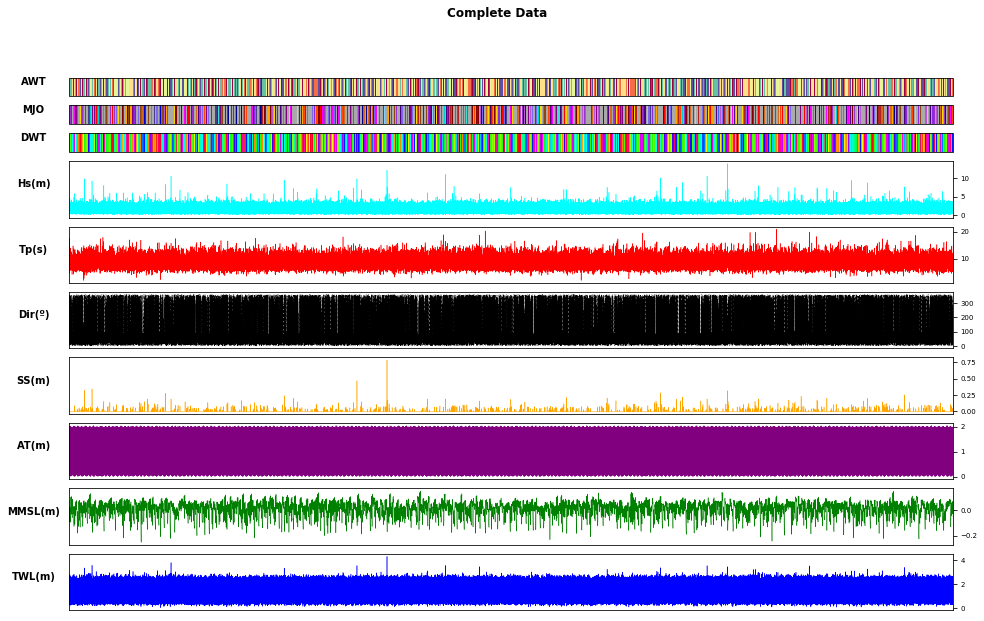

In [9]:
# Plot one Simulation 

Plot_Complete(SIM_COMPLETE_h.sel(n_sim=0));
